# CSE 5095 Team 12 Project

## Import Necessary Libraries

In [ ]:
import os
import shutil
import torch
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ConvertImageDtype, ToTensor
from torchvision.io import read_image
from torch.utils.data.dataloader import default_collate

## Dataset downloading and preprocessing

In [ ]:
# Mount the drive to colab notebook
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
 #Extract the dataset

!unrar x -Y "/content/gdrive/My Drive/VOC2007.rar"

Streaming output truncated to the last 5000 lines.
Extracting  VOC2007/labels/005010859.txt                                  99%  OK 
Extracting  VOC2007/labels/005010860.txt                                  99%  OK 
Extracting  VOC2007/labels/005010861.txt                                  99%  OK 
Extracting  VOC2007/labels/005010862.txt                                  99%  OK 
Extracting  VOC2007/labels/005010863.txt                                  99%  OK 
Extracting  VOC2007/labels/005010864.txt                                  99%  OK 
Extracting  VOC2007/labels/005010865.txt                                  99%  OK 
Extracting  VOC2007/labels/005010866.txt                                  99%  OK 
Extracting  VOC2007/labels/005010867.txt                                  99%  OK 
Extracting  VOC2007/labels/005010868.txt                                  99%  OK 
Extracting  VOC2007/labels/00

In [ ]:
root_dir = "/content/VOC2007"
annotations_dir = os.path.join(root_dir, "Annotations")
images_dir = os.path.join(root_dir, "JPEGImages")
sets_dir = os.path.join(root_dir, "ImageSets", "Main")
labels_dir = os.path.join(root_dir, "labels")

dest_base_dir = os.path.join(root_dir, "dataset_splits")

In [ ]:
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(dest_base_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dest_base_dir, split, 'annotations'), exist_ok=True)
    os.makedirs(os.path.join(dest_base_dir, split, 'labels'), exist_ok=True)

In [ ]:
def distribute_files(files, split):
    with open(files, 'r') as f:
        filenames = f.read().splitlines()

        for filename in filenames:
            image_src = os.path.join(images_dir, filename + '.jpg')
            annotation_src = os.path.join(annotations_dir, filename + '.xml')
            label_src = os.path.join(labels_dir, filename + '.txt')  # Assuming a parallel structure for labels

            image_dest = os.path.join(dest_base_dir, split, 'images', filename + '.jpg')
            annotation_dest = os.path.join(dest_base_dir, split, 'annotations', filename + '.xml')
            label_dest = os.path.join(dest_base_dir, split, 'labels', filename + '.txt')  # Destination for labels

            # Move the files
            shutil.copy(image_src, image_dest)
            shutil.copy(annotation_src, annotation_dest)
            shutil.copy(label_src, label_dest)

for split in ['train', 'val', 'test']:
    distribute_files(os.path.join(sets_dir, split + '.txt'), split)

In [ ]:
class PomegranateDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.txt'))

        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)  # Ensure your transform is compatible with torch tensors

        boxes = []
        with open(label_path, 'r') as f:
            for line in f:
                class_label, x_center, y_center, width, height = [float(x) for x in line.strip().split()]
                boxes.append([class_label, x_center, y_center, width, height])

        boxes = torch.tensor(boxes, dtype=torch.float32)

        return image, boxes

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))  # Remove None items
    images = [item[0] for item in batch]
    boxes = [item[1] for item in batch]

    images = default_collate(images)  # Use the default_collate to handle images

    # Boxes don't need collation into a batch tensor, can be a list
    return images, boxes

transform = Compose([
    ConvertImageDtype(torch.float),  # Convert images to float tensors
    Resize((640, 480)),  # Resize all images to have the same dimensions
])

train_dataset = PomegranateDataset(
    image_dir= os.path.join(dest_base_dir, 'train', 'images'),
    label_dir= os.path.join(dest_base_dir, 'train', 'labels'),
    transform=transform
)

dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

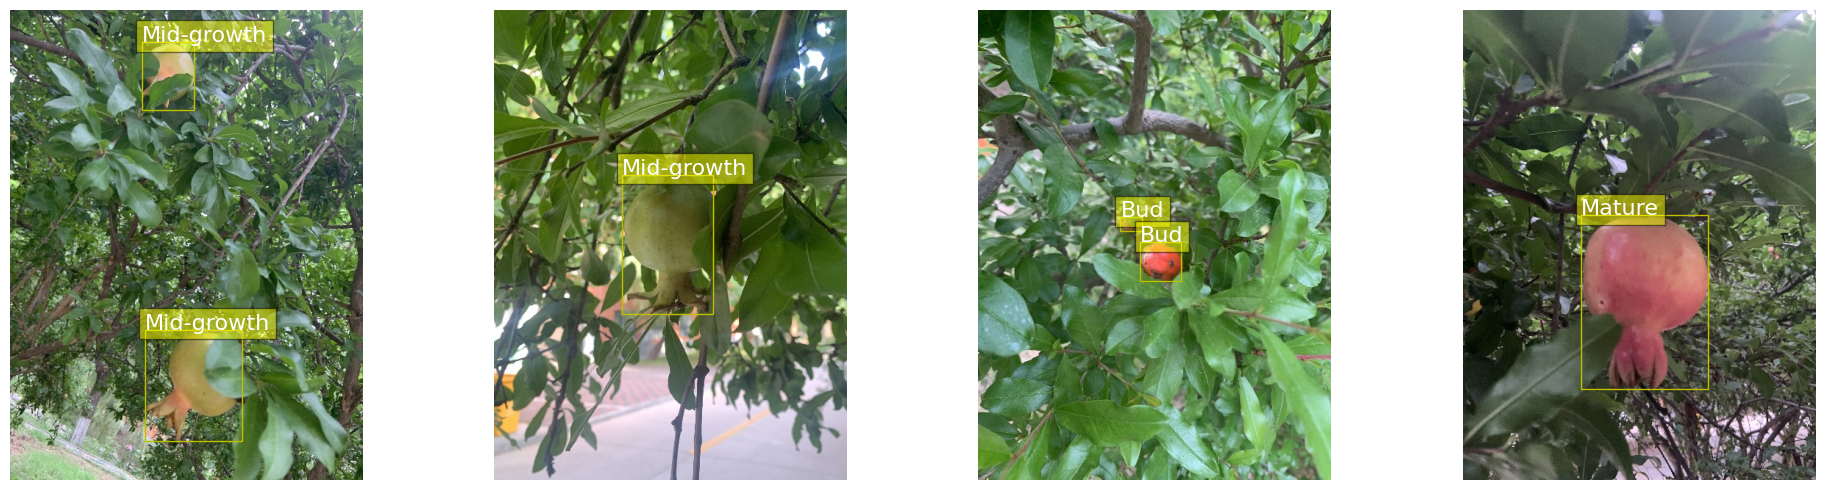

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Mapping from class indices to class names (update this according to your dataset)
class_names = {0: 'Bud', 1: 'Flower', 2: 'Early-fruit', 3: 'Mid-growth', 4: 'Mature'}

# Function to display images with bounding boxes and class names
def show_images_with_boxes(dataloader, num_images=4):
    fig, axs = plt.subplots(1, num_images, figsize=(20, 5))
    for batch_idx, (images, boxes) in enumerate(dataloader):
        if batch_idx >= num_images:
            break
        image = images[batch_idx].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        axs[batch_idx].imshow(image)
        for box in boxes[batch_idx]:
            class_label, x_center, y_center, width, height = box
            # Convert from normalized to image coordinates
            x = (x_center - width / 2) * image.shape[1]
            y = (y_center - height / 2) * image.shape[0]
            width = width * image.shape[1]
            height = height * image.shape[0]
            rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='y', facecolor='none')
            axs[batch_idx].add_patch(rect)
            # Annotate each bounding box with the class name
            label = class_names[class_label.item()]  # Get the class name using the class label
            axs[batch_idx].text(x, y, label, color='white', fontsize=16, bbox=dict(facecolor='yellow', alpha=0.5))
        axs[batch_idx].axis('off')
    plt.tight_layout()
    plt.show()

# Assuming 'dataloader' is already defined and loaded with your dataset
show_images_with_boxes(dataloader)

## Clone the YOLOv5 model

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


## Installing dependencies for YOLOv5

In [ ]:
!pip install -r requirements.txt

## Train the model

In [ ]:
import os
print(os.getcwd())

/content/yolov5


In [ ]:
 !python train.py --img 640 --batch 32 --epochs 2 --data /content/VOC2007/yolov5.yaml --weights yolov5s.pt

2024-05-02 03:17:17.301602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 03:17:17.301652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 03:17:17.302858: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=/content/VOC2007/yolov5.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=2, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, singl

In [ ]:
model.save_weights('./runs/train/exp3')

In [ ]:
!python3 export.py --weights ./runs/train/exp3/weights/best.pt --include onnx engine --img 640 --device 0

export: data=data/coco128.yaml, weights=['./runs/train/exp3/weights/best.pt'], imgsz=[640], batch_size=1, device=0, half=False, inplace=False, keras=False, optimize=False, int8=False, per_tensor=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx', 'engine']
YOLOv5 🚀 v7.0-306-gb599ae42 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from runs/train/exp3/weights/best.pt with output shape (1, 25200, 10) (13.7 MB)
requirements: Ultralytics requirement ['nvidia-tensorrt'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.9/340.9 MB 211.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'don

In [ ]:
 !python train.py --img 640 --batch 32 --epochs 2 --data /content/VOC2007/yolov5.yaml --weights ./runs/train/exp3/weights/best.pt

python3: can't open file '/content/train.py': [Errno 2] No such file or directory
